# Machine Learning Project: Predicting Race Performance from Practice Data

Below is a demonstration of how the F1Analytics class is used in practice.

These plots and outputs illustrate the class’s functionality.

The interpretation of these plots and results is provided in the main report.

If certain plots are not included in the written report, their analysis will instead be presented during the oral presentation.

### Create an instance

In [1]:
from f1_analytics import F1Analytics
obj = F1Analytics()

## Task 1: Classification with SVC

Here I use a Support Vector Classifier (SVC) to predict whether a driver will finish in the top ten (with points) based solely on FP data.

### Testing different kernels and misclassification penalties ($C$)

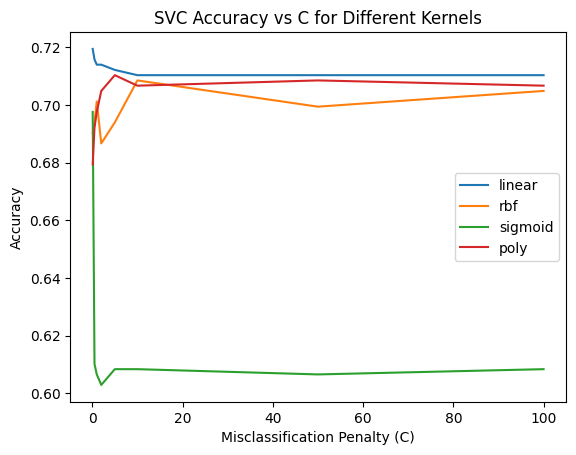

Highest accuracy of 0.72 with: Kernel = linear and C = 0.1 


In [2]:
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
cs = [0.1, 0.5, 1, 2, 5, 10, 50, 100]

best_kernel, best_c = obj.svc_kernel_analysis(kernels = kernels, cs = cs, plot = True)

### Classification report and confusion matrix

------------------- Kernel: linear C = 0.1 -------------------
               precision    recall  f1-score   support

    No Points       0.72      0.74      0.73       279
Scored Points       0.72      0.70      0.71       270

     accuracy                           0.72       549
    macro avg       0.72      0.72      0.72       549
 weighted avg       0.72      0.72      0.72       549



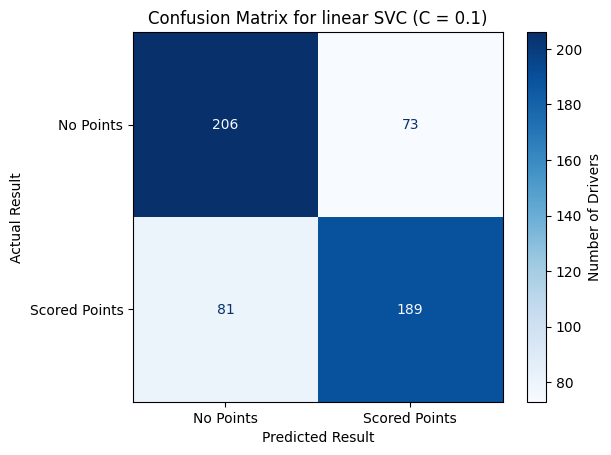

In [3]:
svc_model = obj.train_svc(kernel = best_kernel, c = best_c, report = True, conf_matrix = True)

## Task 2: Bayesian and Probabilistic Modeling

A Beta-Binomial model was used to estimate the probability that a driver finishes ahead of their teammate in the race, given whether they were faster or slower in FP. As a prior belief, I assumed no knowledge about the relationship between FP and race performance. 

$$\textbf{Prior:} \quad \theta \sim Beta(1, 1)$$

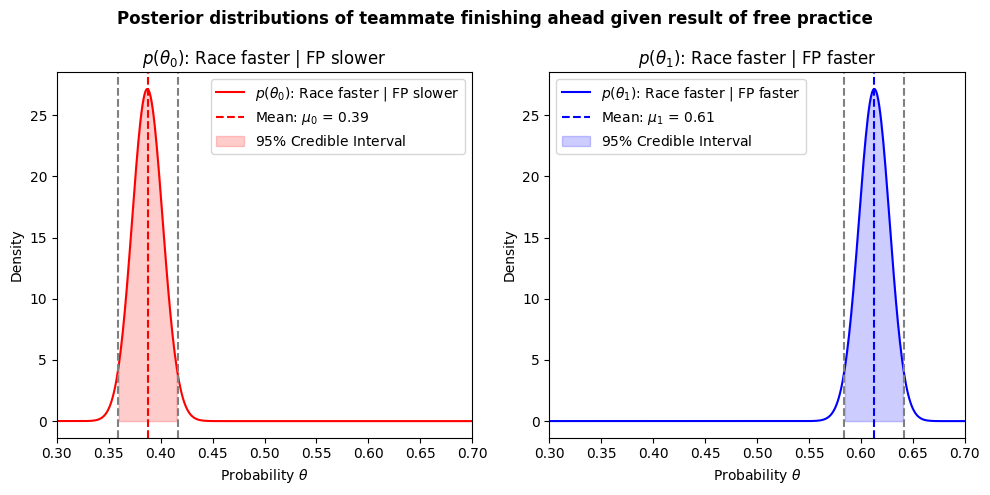

Prior: Beta(1, 1)
Prior mean: 0.50 (50.0%)

Race faster | FP faster
Posterior: Beta(674, 426)
Posterior mean: 0.61 (61.3%)

Race faster | FP slower
Posterior: Beta(426, 674)
Posterior mean: 0.39 (38.7%)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

#Prior belief
alpha_prior = 1
beta_prior = 1
prior_mean  = alpha_prior / (alpha_prior + beta_prior)

result = obj.get_posterior(alpha_prior = alpha_prior, beta_prior = beta_prior, n_theta = 1000)

#Get results
ci_lower = result['ci_lower']
ci_upper = result['ci_upper']
post_pdf = result['post_pdf']
post_mean = result['post_mean']
alpha_post = result['alpha_post']
beta_post = result['beta_post']

# Grid for θ
theta = np.linspace(0, 1, 1000)

#Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(theta, post_pdf[0], '-',label = r'$p(\theta_0)$: Race faster | FP slower', color = 'red')
plt.axvline(post_mean[0], color='red', linestyle='--', label=rf'Mean: $\mu_0$ = {post_mean[0]:.2f}')
plt.axvline(ci_lower[0], linestyle = '--', color = 'grey')
plt.axvline(ci_upper[0], linestyle = '--', color = 'grey')
plt.fill_between(theta, post_pdf[0], where=(theta >= ci_lower[0]) & (theta <= ci_upper[0]), alpha=0.2, color = 'red', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_0)$: Race faster | FP slower')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(theta, post_pdf[1], '-',label = r'$p(\theta_1)$: Race faster | FP faster', color = 'blue')
plt.axvline(post_mean[1], color='blue', linestyle='--', label=rf'Mean: $\mu_1$ = {post_mean[1]:.2f}')
plt.axvline(ci_lower[1], linestyle = '--', color = 'grey')
plt.axvline(ci_upper[1], linestyle = '--', color = 'grey')
plt.fill_between(theta, post_pdf[1], where=(theta >= ci_lower[1]) & (theta <= ci_upper[1]), alpha=0.2, color = 'blue', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_1)$: Race faster | FP faster')
plt.legend()

plt.suptitle('Posterior distributions of teammate finishing ahead given result of free practice', fontweight='bold')
plt.tight_layout()
plt.show()

#Prior belief
print(f'Prior: Beta({alpha_prior}, {beta_prior})')
print(f'Prior mean: {prior_mean:.2f} ({prior_mean*100:.1f}%)')

#Posterior belief
print('\nRace faster | FP faster')
print(f'Posterior: Beta({alpha_post[1]}, {beta_post[1]})')
print(f'Posterior mean: {post_mean[1]:.2f} ({post_mean[1]*100:.1f}%)')

print('\nRace faster | FP slower')
print(f'Posterior: Beta({alpha_post[0]}, {beta_post[0]})')
print(f'Posterior mean: {post_mean[0]:.2f} ({post_mean[0]*100:.1f}%)')

# Predict the fastest lap in the race using Free Practice data (From Enrico's class)

The objective was to predict the fastest race lap using FP data, so I began by evaluating linear regression as a simple yet effective modeling approach. To improve performance, I compared several regularized linear models across different polynomial degrees.

### Comparing several regularized linear models across different polynomial degrees

In [5]:
models = ['ElasticNet','Lasso', 'Ridge', 'LinearRegression']
for model in models:
    obj.train_lin_reg(model_name = model, l1_ratio = 0.5, poly_order = 1, scores = True)

------------------- Model: ElasticNet ------------------- 
Best α: 0.005
Best MAE: 1.429
MAE: 1.429 ± 0.291
R²:  0.883 ± 0.064
------------------- Model: Lasso ------------------- 
Best α: 0.027
Best MAE: 1.431
MAE: 1.431 ± 0.278
R²:  0.885 ± 0.063
------------------- Model: Ridge ------------------- 
Best α: 7.055
Best MAE: 1.428
MAE: 1.428 ± 0.290
R²:  0.883 ± 0.064
------------------- Model: LinearRegression ------------------- 
Best MAE: 1.435
MAE: 1.435 ± 0.292
R²:  0.882 ± 0.065


### The chosen model

I selected ElasticNet with an $l_1$-ratio of $0.7$ as the final model, as this places more weight on the Lasso penalty. Lasso helps remove weak or noisy coefficients, while the Ridge component keeps the model stable.

In [6]:
best_model = obj.train_lin_reg(model_name = 'ElasticNet', l1_ratio = 0.7, poly_order = 1, scores = True)

------------------- Model: ElasticNet ------------------- 
Best α: 0.007
Best MAE: 1.429
MAE: 1.429 ± 0.290
R²:  0.884 ± 0.064


### Plotting most influential features 

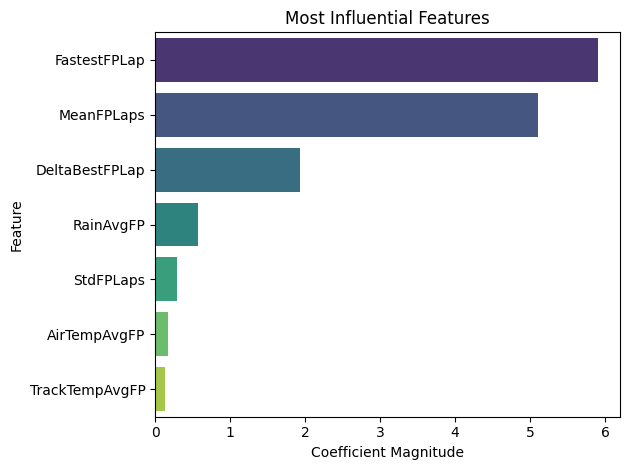

          Feature  Coefficient  AbsValue
0    FastestFPLap     5.902356  5.902356
1      MeanFPLaps     5.102957  5.102957
2  DeltaBestFPLap     1.930246  1.930246
3       RainAvgFP    -0.571678  0.571678
4       StdFPLaps     0.293103  0.293103
5    AirTempAvgFP     0.165440  0.165440
6  TrackTempAvgFP    -0.125267  0.125267


In [7]:
coef_df = obj.get_most_influential_features(model = best_model)
print(coef_df.head(len(coef_df)))

### Testing on new unseen $2025$ data

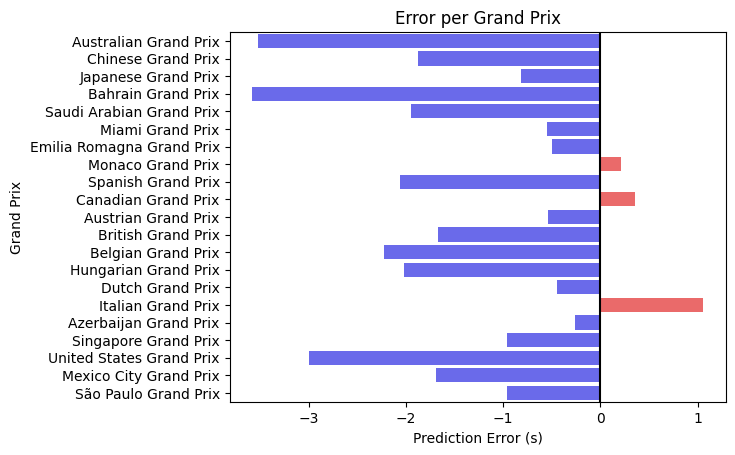

In [8]:
results_df = obj.test_lin_reg_model(model = best_model, own_data = False)

In [9]:
print(results_df)

                           GP   Predicted   Actual     Error   Sign
0       Australian Grand Prix   78.644090   82.167 -3.522910  False
1          Chinese Grand Prix   93.192203   95.069 -1.876797  False
2         Japanese Grand Prix   90.148196   90.965 -0.816804  False
3          Bahrain Grand Prix   91.555741   95.140 -3.584259  False
4    Saudi Arabian Grand Prix   89.825333   91.778 -1.952667  False
5            Miami Grand Prix   89.192830   89.746 -0.553170  False
6   Emilia Romagna Grand Prix   77.485559   77.988 -0.502441  False
7           Monaco Grand Prix   73.429485   73.221  0.208485   True
8          Spanish Grand Prix   73.679191   75.743 -2.063809  False
9         Canadian Grand Prix   74.471234   74.119  0.352234   True
10        Austrian Grand Prix   67.379778   67.924 -0.544222  False
11         British Grand Prix   87.669776   89.337 -1.667224  False
12         Belgian Grand Prix  102.634687  104.861 -2.226313  False
13       Hungarian Grand Prix   77.383490   79.4